<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: Юрий Исаков и Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 4. Линейные модели классификации и регрессии
## <center>  Практика. Идентификация пользователя с помощью логистической регрессии

Тут мы воспроизведем парочку бенчмарков нашего соревнования и вдохновимся побить третий бенчмарк, а также остальных участников. Веб-формы для отправки ответов тут не будет, ориентир – [leaderboard](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/leaderboard) соревнования.

In [1]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
sklearn.__version__

'0.19.0'

### 1. Загрузка и преобразование данных
Зарегистрируйтесь на [Kaggle](www.kaggle.com), если вы не сделали этого раньше, зайдите на [страницу](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) соревнования и скачайте данные. Первым делом загрузим обучающую и тестовую выборки и посмотрим на данные.

In [2]:
# загрузим обучающую и тестовую выборки
train_df = pd.read_csv('../../data/train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('../../data/test_sessions.csv',
                      index_col='session_id')

# приведем колонки time1, ..., time10 к временному формату
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# отсортируем данные по времени
train_df = train_df.sort_values(by='time1')

In [3]:
# посмотрим на заголовок обучающей выборки
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


В обучающей выборке содержатся следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - target – целевая переменная, 1 для сессий Элис, 0 для сессий других пользователей
    
Сессии пользователей выделены таким образом, что они не могут быть длиннее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд либо когда сессия заняла по времени более 30 минут.

В таблице встречаются пропущенные значения, это значит, что сессия состоит менее, чем из 10 сайтов. Заменим пропущенные значения нулями и приведем признаки к целому типу. Также загрузим словарь сайтов и посмотрим, как он выглядит:

In [4]:
# приведем колонки site1, ..., site10 к целочисленному формату и заменим пропуски нулями
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# загрузим словарик сайтов
with open(r"../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# датафрейм словарика сайтов
sites_dict_df = pd.DataFrame(list(site_dict.keys()), 
                          index=list(site_dict.values()), 
                          columns=['site'])
print(u'всего сайтов:', sites_dict_df.shape[0])
sites_dict_df.head()

всего сайтов: 48371


,site
39839,wiki.scienceamusante.net
31090,cf.figureprints.com
35476,healthsciences.unimelb.edu.au
5289,supercore.s3.amazonaws.com
46627,abfkzw.dm1.livefilestore.com


Выделим целевую переменную и объединим выборки, чтобы вместе привести их к разреженному формату.

In [5]:
y_train = train_df['target']

### 2. Построение первой модели

In [36]:
from sklearn.model_selection import train_test_split

def get_auc_lr_valid(X, y, est=None, C=1.0, ratio = 0.9, seed=17):
    '''
    X, y – выборка
    ratio – в каком отношении поделить выборку
    C, seed – коэф-т регуляризации и random_state 
              логистической регрессии
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 - ratio), shuffle=False, stratify=None)
    if est is None:
        est = LogisticRegression(C=C, random_state=seed)
    est.fit(X_train, y_train)
    return roc_auc_score(y_test, est.predict_proba(X_test)[:, 1])

**Посмотрите, какой получился ROC AUC на отложенной выборке.**

Будем считать эту модель нашей первой отправной точкой (baseline). Для построения модели для прогноза на тестовой выборке **необходимо обучить модель заново уже на всей обучающей выборке** (пока наша модель обучалась лишь на части данных), что повысит ее обобщающую способность:

In [7]:
# функция для записи прогнозов в файл
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

Если вы выполните эти действия и загрузите ответ на [странице](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) соревнования, то воспроизведете первый бенчмарк "Logit".

### 3. Улучшение модели, построение новых признаков

Создайте такой признак, который будет представлять собой число вида ГГГГММ от той даты, когда проходила сессия, например 201407 -- 2014 год и 7 месяц. Таким образом, мы будем учитывать помесячный [линейный тренд](http://people.duke.edu/~rnau/411trend.htm) за весь период предоставленных данных.

In [8]:
new_train = pd.DataFrame(index=train_df.index)
new_test = pd.DataFrame(index=test_df.index)

In [9]:
def scale_feature(train, test, feat_name):
    scaler = StandardScaler()
    scaler.fit(train[feat_name].astype('float64').values.reshape(-1, 1))
    train[feat_name + '_s'] = scaler.transform(train[feat_name].astype('float64').values.reshape(-1, 1))
    test[feat_name + '_s'] = scaler.transform(test[feat_name].astype('float64').values.reshape(-1, 1))    

### Месяц начала сессии

In [10]:
def transform_sess_start(ts):
    return ts.year*100 + ts.month

new_train['year_month'] = train_df['time1'].apply(transform_sess_start)
new_test['year_month'] = test_df['time1'].apply(transform_sess_start)

In [11]:
scale_feature(new_train, new_test, 'year_month')

### Время начала сессии и утро ли

In [12]:
def get_hour(ts):
    return ts.hour

def get_morning(ts):
    if ts.hour <= 11:
        return 1
    else:
        return 0
    
new_train['start_hour'] = train_df['time1'].apply(get_hour)
new_test['start_hour'] = test_df['time1'].apply(get_hour)
new_train['morning'] = train_df['time1'].apply(get_morning)
new_test['morning'] = test_df['time1'].apply(get_morning)

In [13]:
scale_feature(new_train, new_test, 'start_hour')

### Продолжительность сессии в секундах

In [14]:
def get_sess_length(row):
    dropped_row = row.dropna()
    length_ts = dropped_row.iloc[-1] - dropped_row.iloc[-(2%len(dropped_row))]
    return length_ts/np.timedelta64(1, 's')

new_train['sess_length'] = train_df[times].apply(get_sess_length, axis=1)
new_test['sess_length'] = test_df[times].apply(get_sess_length, axis=1)

In [15]:
scale_feature(new_train, new_test, 'sess_length')

### Количество посещенных сайтов

In [16]:
def get_site_count(row):
    dropped_row = row.dropna()
    return len(dropped_row)

new_train['site_count'] = train_df[times].apply(get_site_count, axis=1)
new_test['site_count'] = test_df[times].apply(get_site_count, axis=1)

In [17]:
scale_feature(new_train, new_test, 'site_count')

### Сессия больше 3 минут

In [18]:
def get_more3min(val):
    if val > 3*60:
        return 1
    else:
        return 0

new_train['more5min'] = new_train['sess_length'].apply(get_more3min)
new_test['more5min'] = new_test['sess_length'].apply(get_more3min)

### Вечер ли(час >18)

In [19]:
def get_evening(ts):
    if ts.hour >= 19:
        return 1
    else:
        return 0
    
new_train['evening'] = train_df['time1'].apply(get_evening)
new_test['evening'] = test_df['time1'].apply(get_evening)

### Дни недели и выходные

In [20]:
new_train['is_weekend'] = train_df['time1'].apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)
new_test['is_weekend'] = test_df['time1'].apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)

In [21]:
new_train = pd.concat([new_train, pd.get_dummies(train_df['time1'].apply(lambda x: x.date().weekday()), prefix='weekday')], axis=1)
new_test = pd.concat([new_test, pd.get_dummies(test_df['time1'].apply(lambda x: x.date().weekday()), prefix='weekday')], axis=1)

### Время проведенное на сайтах

In [22]:
def get_times(row):
    values1 = row.values
    values2 = np.roll(values1, -1)
    return (values2 - values1)/np.timedelta64(1, 's')
    
times = ['time%s' % i for i in range(1, 11)]
times9 = ['time%s' % i for i in range(1, 10)]
new_train[times] = train_df[times].apply(get_times, axis=1).fillna(0)
new_train['time10'] = 0
new_test[times] = test_df[times].apply(get_times, axis=1).fillna(0)
new_test['time10'] = 0

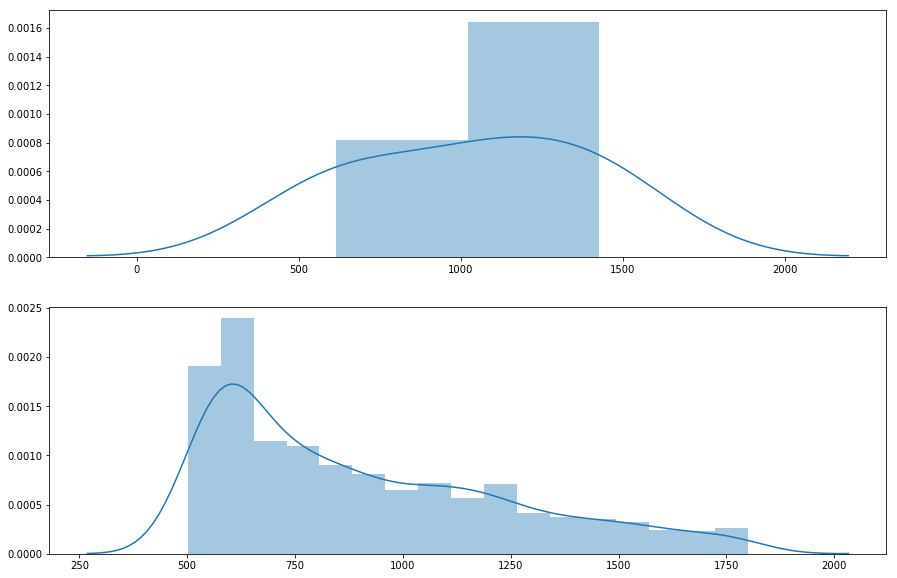

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
time_attr = ['sess_length']
arr1 = new_train[time_attr][y_train == 1].values.reshape(-1, 1)
sns.distplot(arr1[arr1 > 500], ax=ax[0])
arr2 = new_train[time_attr][y_train == 0].values.reshape(-1, 1)
sns.distplot(arr2[arr2 > 500], ax=ax[1])

In [73]:
arr1[arr1 > 100].shape

(27,)

In [76]:
def length_more200(val):
    if val > 650:
        return 1
    else:
        return 0

new_train['more200'] = new_train['sess_length'].apply(length_more200)
new_test['more200'] = new_train['sess_length'].apply(length_more200)

In [77]:
new_train.head()

,year_month,year_month_s,start_hour,morning,start_hour_s,sess_length,sess_length_s,site_count,site_count_s,more5min,...,time3,time4,time5,time6,time7,time8,time9,time10,more650,more200
session_id,,,,,,,,,,,,,,,,,,,,,
21669,201301,-1.744405,8,1,-1.357366,0.0,-0.203780,2,-4.328969,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
54843,201301,-1.744405,8,1,-1.357366,2.0,-0.183457,4,-3.177031,0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
77292,201301,-1.744405,8,1,-1.357366,0.0,-0.203780,10,0.278784,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0
114021,201301,-1.744405,8,1,-1.357366,1.0,-0.193619,10,0.278784,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,0
146670,201301,-1.744405,8,1,-1.357366,0.0,-0.203780,10,0.278784,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0


### Tf-Idf

In [25]:
time_interval = 20
def convert_sites_to_sequence(row, new_df):
    new_row = new_df.loc[row.name, :]
    return ' '.join(['s{}_{}'.format(str(obj[0]), str(int(obj[1]/time_interval))) 
                     for obj in zip(row.values, new_row[times].values) if obj[0] != 0])

In [26]:
corpus_train = train_df[sites].apply(lambda row: convert_sites_to_sequence(row, new_train), axis=1).values
corpus_test = test_df[sites].apply(lambda row: convert_sites_to_sequence(row, new_test), axis=1).values

In [27]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95)

In [28]:
X_train_sparse = vectorizer.fit_transform(corpus_train)
X_test_sparse = vectorizer.transform(corpus_test)

In [29]:
X_train_sparse.shape, X_test_sparse.shape

((253561, 1378352), (82797, 1378352))

In [40]:
lgr = LogisticRegression()
get_auc_lr_valid(X_train_sparse, y_train, est=lgr)

0.9211110426788105

### Настройка дополнительных признаков

In [49]:
weekday_col = ['weekday_%i' % i for i in range(0, 7)]
times_col = ['time%s' % i for i in range(1, 10)]
columns = ['year_month_s', 'start_hour_s', 'morning', 'evening', 'site_count_s', 'sess_length_s', 'is_weekend'] + weekday_col

In [37]:
import lightgbm as lgb

X_train_add = new_train[columns]
X_test_add = new_test[columns]
gbm = lgb.LGBMClassifier()

In [38]:
get_auc_lr_valid(X_train_add, y_train, est=gbm)

0.94760868357588557

### Votings ensemble

In [98]:
lgr = LogisticRegression().fit(X_train_sparse, y_train)
lgr_test = lgr.predict_proba(X_train_sparse)[:, 0]
gbm = lgb.LGBMClassifier().fit(X_train_add, lgr_test)
result1 = lgr.predict_proba(X_test_sparse)[:, 1]
result2 = gbm.predict_proba(X_test_add)[:, 1]
result = []
for i in range(len(result1)):
    result.append(np.sum([result1[i], result2[i]]))
write_to_submission_file(np.array(result), './../../data/alice_result3.csv')

ValueError: Unknown label type: 'continuous'

### Объеденение фич

In [87]:
weekday_col = ['weekday_%i' % i for i in range(0, 7)]
times_col = ['time%s' % i for i in range(1, 10)]
columns = ['year_month_s', 'start_hour_s', 'morning', 'evening', 'site_count_s', 'sess_length_s', 'is_weekend', 'more200'] + weekday_col

In [88]:
X_train = csr_matrix(hstack([X_train_sparse, new_train[columns].values]))
X_test = csr_matrix(hstack([X_test_sparse, new_test[columns].values]))

In [89]:
get_auc_lr_valid(X_train, y_train)

0.98001359186251391

Постараемся побить этот результат за счет оптимизации коэффициента регуляризации. Возьмем набор возможных значений C и для каждого из них посчитаем значение метрики на отложенной выборке.

Найдите `C` из `np.logspace(-3, 1, 10)`, при котором ROC AUC на отложенной выборке максимален. 

In [42]:
for C in [0.001, 0.01, 0.1, 0.5, 1, 1.5, 2, 3, 5]:
    print('C: ', C, 'ROC_AUC: ', get_auc_lr_valid(X_train, y_train, C=C))

NameError: name 'X_train' is not defined

In [295]:
est = LogisticRegression(C=3)
est.fit(X_train, y_train)
y_pred = est.predict_proba(X_test)[:, 1]
write_to_submission_file(y_pred, './../../data/alice_result3.csv')